In [19]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

In [33]:
audio_path = './Audio_Files/Major/Major_0.wav'
x , sr = librosa.load(audio_path,sr=44100)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


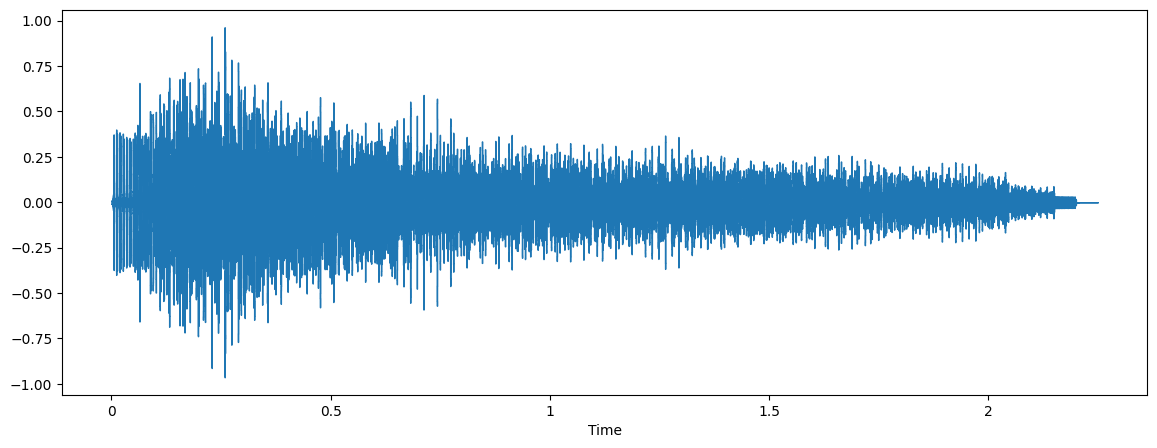

In [34]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

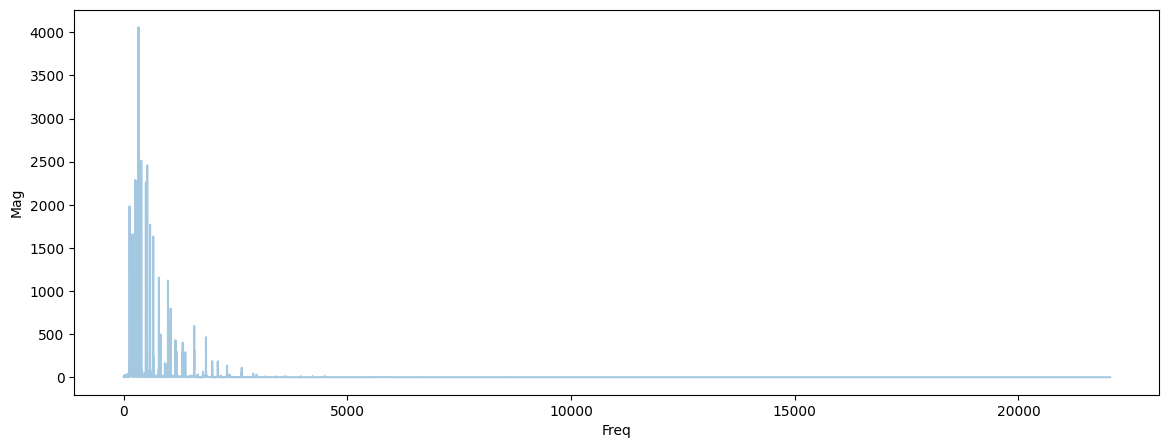

In [35]:
fft = np.fft.fft(x)
spectrum = np.abs(fft)
left_spectrum = spectrum[:int(len(spectrum)/2)]
f = np.linspace(0, sr, len(spectrum))
left_f = f[:int(len(spectrum)/2)]
# plot spectrum
plt.figure(figsize=(14, 5))
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel("Freq")
plt.ylabel("Mag")
plt.show()

[[  2.0335736   13.567068    17.684538   ... -34.83098    -34.83098
  -34.83098   ]
 [  1.4057539   11.058221    12.288009   ... -34.83098    -34.83098
  -34.83098   ]
 [ -0.47513354   3.2502613  -24.608093   ... -34.83098    -34.83098
  -34.83098   ]
 ...
 [-34.83098    -34.83098    -34.83098    ... -34.83098    -34.83098
  -34.83098   ]
 [-34.83098    -34.83098    -34.83098    ... -34.83098    -34.83098
  -34.83098   ]
 [-34.83098    -34.83098    -34.83098    ... -34.83098    -34.83098
  -34.83098   ]]


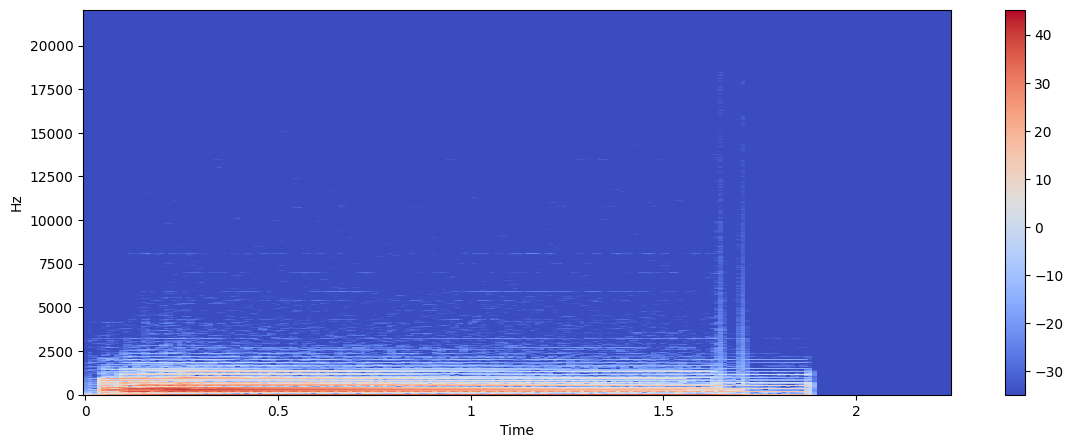

In [32]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
print(Xdb)
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

(20, 194)


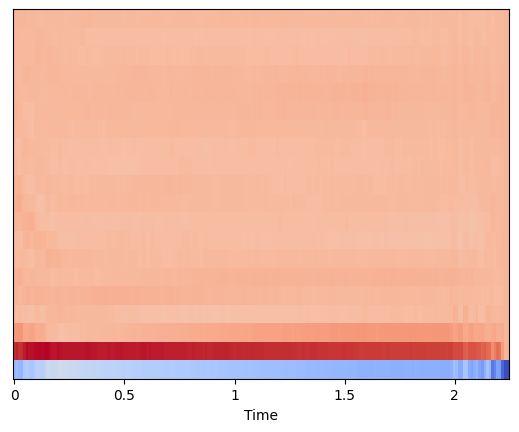

In [23]:
mfccs = librosa.feature.mfcc(y=x, sr=sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')